In [4]:
#imports
import pandas as pd
import gzip
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import opinion_lexicon
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize

import math
import numpy as np
import spacy
import pickle
import random
nlp = spacy.load("en_core_web_sm")
%matplotlib notebook


In [5]:
#constants 
TOP_N=10
PRODUCT_RECIPIENT_WORDS=['kid', 'son', 'grandson', 'daughter', 'grandaughter', 'nephew', 'niece', 'child', 'husband','wife']
PRODUCT_RECIPIENT="product_recipient"
PRODUCT_WORDS=['product','car','toy','car','item','thing']
PRODUCT="product"

# Load data

In [6]:
#import dataset
top_car_reviews= pd.read_pickle('dataset/top_car_reviews.pkl')
top_car_reviews

,overall,verified,asin,reviewerID,reviewText,summary,title,price
0,5.0,True,B00005LBZO,A2VY5QVWBX2YB3,I remember playing with Kettcars when I was a ...,A Great Toy for any Child!,"Kettler Kettcar Kabrio Cart, Yellow",
1,5.0,True,B00005LBZO,A2VY5QVWBX2YB3,I remember playing with Kettcars when I was a ...,A Great Toy for any Child!,"Kettler Kettcar Kabrio Cart, Yellow",
2,5.0,False,B00005LBZO,A136AQL8RG5WJJ,I am so very pleased with this product! I boug...,Kettler Karibo Cart,"Kettler Kettcar Kabrio Cart, Yellow",
3,5.0,False,B00005LBZO,A136AQL8RG5WJJ,I am so very pleased with this product! I boug...,Kettler Karibo Cart,"Kettler Kettcar Kabrio Cart, Yellow",
4,5.0,False,B00005LBZO,A2X3VRF0KE4C1Q,"One of the best ride on toys for ""little peopl...",A better pedal car....,"Kettler Kettcar Kabrio Cart, Yellow",
...,...,...,...,...,...,...,...,...
2045,1.0,True,B01CWSRW62,A2U221MZ3INE7U,"Stopped working after about 30-40 days, total ...","Good for 2 hours of play, then dies.",ZHMY Remote control Stunt Car Double-face work...,$5.24
2046,5.0,True,B01CWSRW62,APFZRYC2NR7XO,It's impossible to get this thing stuck!,Five Stars,ZHMY Remote control Stunt Car Double-face work...,$5.24
2047,5.0,True,B01CWSRW62,A16AHSSEEFOXU5,My husband and our dog love it. It is very stu...,My husband and our dog love it. It is very stu...,ZHMY Remote control Stunt Car Double-face work...,$5.24
2048,1.0,True,B01CWSRW62,A291Y0FXKMLYFE,Don't buy this. Was fun for only a brief time...,Was fun for only a brief time before it stoppe...,ZHMY Remote control Stunt Car Double-face work...,$5.24


In [7]:
#gets all reviews for a given product as a list of strings
def get_reviews(df, asin):
    return df[df["asin"]==asin]["reviewText"].tolist()

In [8]:
review_list=get_reviews(top_car_reviews,'B01CA4R218')
review_list
for review in review_list:
    print(review)
    print()

All writing on the box was in Chinese.  The car had more bells and whistles than stated.

car is well made and works so different from other cars I have bought my grand sons. ending up buying all 3 listed for him for Christmas

Son loves it

Smaller than I was expecting
 But nice product.

Love this one and so will my grandson. The color is beautiful and quality is top.

This car was for my nephew and he loves it!

too small, need nails to open front engine. color is okay not shiny as it looks.  Instructions in Chinese.  My 2 year old loved it when he saw pictures online but was not that attractive to him when i gave it as a give.

Got this for my nephew and he loves it. Definitely satisfied with my purchase.

love it

Answering for my grandson who loves this car!

My son loves collecting cars. This is awesome looking with great features!

This is my grandsons favorite diecast car.  Great quality

This was a surprising find. Sounds, lights, and doors opening make it a lot of fun. And, 

In [6]:
test_review=review_list[7]
test_review

'This is the ride my 3 1/2 year old son prefers to all other ride-on toys.  He has a bike, a motorized Jeep, a cozy coupe (ride in plastic car), a wagon, and a stradle on 4 wheel bus.  He needs to ride this car everyday and it is not even our toy.  The neighbor purchased this Kettcar in a yard sale.  Her son is too small to reach the petals and my son has taken this car over.\nHe rides faster in it than any other bike.  It is very safe and low to the ground.  I am not worried about it tipping over like I am with his bike.  He passes all the motorized toys in the neighborhood.  He LOVES it! And he gets some exercise!'

# Noun extraction (simple)

In [7]:
def isNaN(num):
    try:
        num=float(num)
    except:
        return False 
    return math.isnan(num)
#takes in a review and returs all nouns in the review
def get_nouns(text):
    
    if isNaN(text):
        return []
    sentences = nltk.sent_tokenize(text) #tokenize sentences
    nouns = [] #empty to array to hold all nouns

    for sentence in sentences:
         for word,pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
             if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
                 nouns.append(word)
    return nouns

noun_list=get_nouns(test_review)

In [8]:
noun_list

['ride',
 'year',
 'son',
 'prefers',
 'toys',
 'bike',
 'Jeep',
 'cozy',
 'coupe',
 'car',
 'wagon',
 'stradle',
 'wheel',
 'bus',
 'car',
 'everyday',
 'toy',
 'neighbor',
 'Kettcar',
 'sale',
 'son',
 'petals',
 'son',
 'car',
 'bike',
 'ground',
 'bike',
 'toys',
 'neighborhood',
 'exercise']

# Noun list processing and consolidation

In [9]:
#takes a list of words and lemmatize then all, returns list of lemmatize words
def lem_list(words):
    lemmatizer = WordNetLemmatizer()
    
    lem_list=[]
    
    for word in words:
        lem_list.append(lemmatizer.lemmatize(word))
    return lem_list
noun_list=lem_list(noun_list)
#noun_list

In [10]:
#get list of words in title of given product
def get_title_words(asin):
    title=top_car_reviews.loc[top_car_reviews["asin"]==asin,"title"].unique()[0]
    title=title.lower()
    #print(title)
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_list = tokenizer.tokenize(title)
    
    return word_list
get_title_words("B00005LBZO")

['kettler', 'kettcar', 'kabrio', 'cart', 'yellow']

In [11]:
#get all nouns from all reviews in list
def get_nouns_all_reviews(review_list, get_fuc=get_nouns):
    all_nouns=[]
    for review in review_list:
        noun_list=get_fuc(review)
        
        #add to main list
        all_nouns.extend(noun_list)
    
    return all_nouns
#get list
all_nouns=get_nouns_all_reviews(review_list)

#preform cleaning 
#lemmatize
all_nouns=lem_list(all_nouns)

#make all words lower cases
all_nouns = [each_string.lower() for each_string in all_nouns]

#remove stop words from list
all_nouns = [word for word in all_nouns if word not in stopwords.words('english')]


print(len(all_nouns))
all_nouns

770


['kettcars',
 'person',
 'germany',
 'child',
 'neighborhood',
 'kid',
 'year',
 'part',
 'yr',
 "'ab'use",
 'seat',
 'son',
 'kettcar',
 'home',
 'seat',
 'family',
 'child',
 'year',
 'granddaugher',
 'kettcar',
 'generation',
 'family',
 'kettcars',
 'car',
 'today',
 'fact',
 'husband',
 'flaw',
 'brake',
 'product',
 'model',
 'child',
 'gr-dtr',
 'company',
 'one',
 'kid',
 'toy',
 'generation',
 'too.',
 'nbsp',
 'class=',
 'href=',
 '/kettler-kettcar-kabrio-cart/dp/b00005lbzo/ref=cm_cr_arp_d_rvw_txt',
 'ie=utf8',
 'kettler',
 'kettcar',
 'kabrio',
 'cart',
 '<',
 '/a',
 '>',
 'kettcars',
 'person',
 'germany',
 'child',
 'neighborhood',
 'kid',
 'year',
 'part',
 'yr',
 "'ab'use",
 'seat',
 'son',
 'kettcar',
 'home',
 'seat',
 'family',
 'child',
 'year',
 'granddaugher',
 'kettcar',
 'generation',
 'family',
 'kettcars',
 'car',
 'today',
 'fact',
 'husband',
 'flaw',
 'brake',
 'product',
 'model',
 'child',
 'gr-dtr',
 'company',
 'one',
 'kid',
 'toy',
 'generation',
 'too

In [12]:
#count word ocerence
count_n=Counter(all_nouns).most_common(10)
print("{} : {}".format("blah",count_n))

blah : [('year', 40), ('car', 38), ('kid', 28), ('son', 24), ('toy', 18), ('time', 18), ('bike', 14), ('kettcar', 12), ('cart', 12), ('pedal', 12)]


<IPython.core.display.Javascript object>


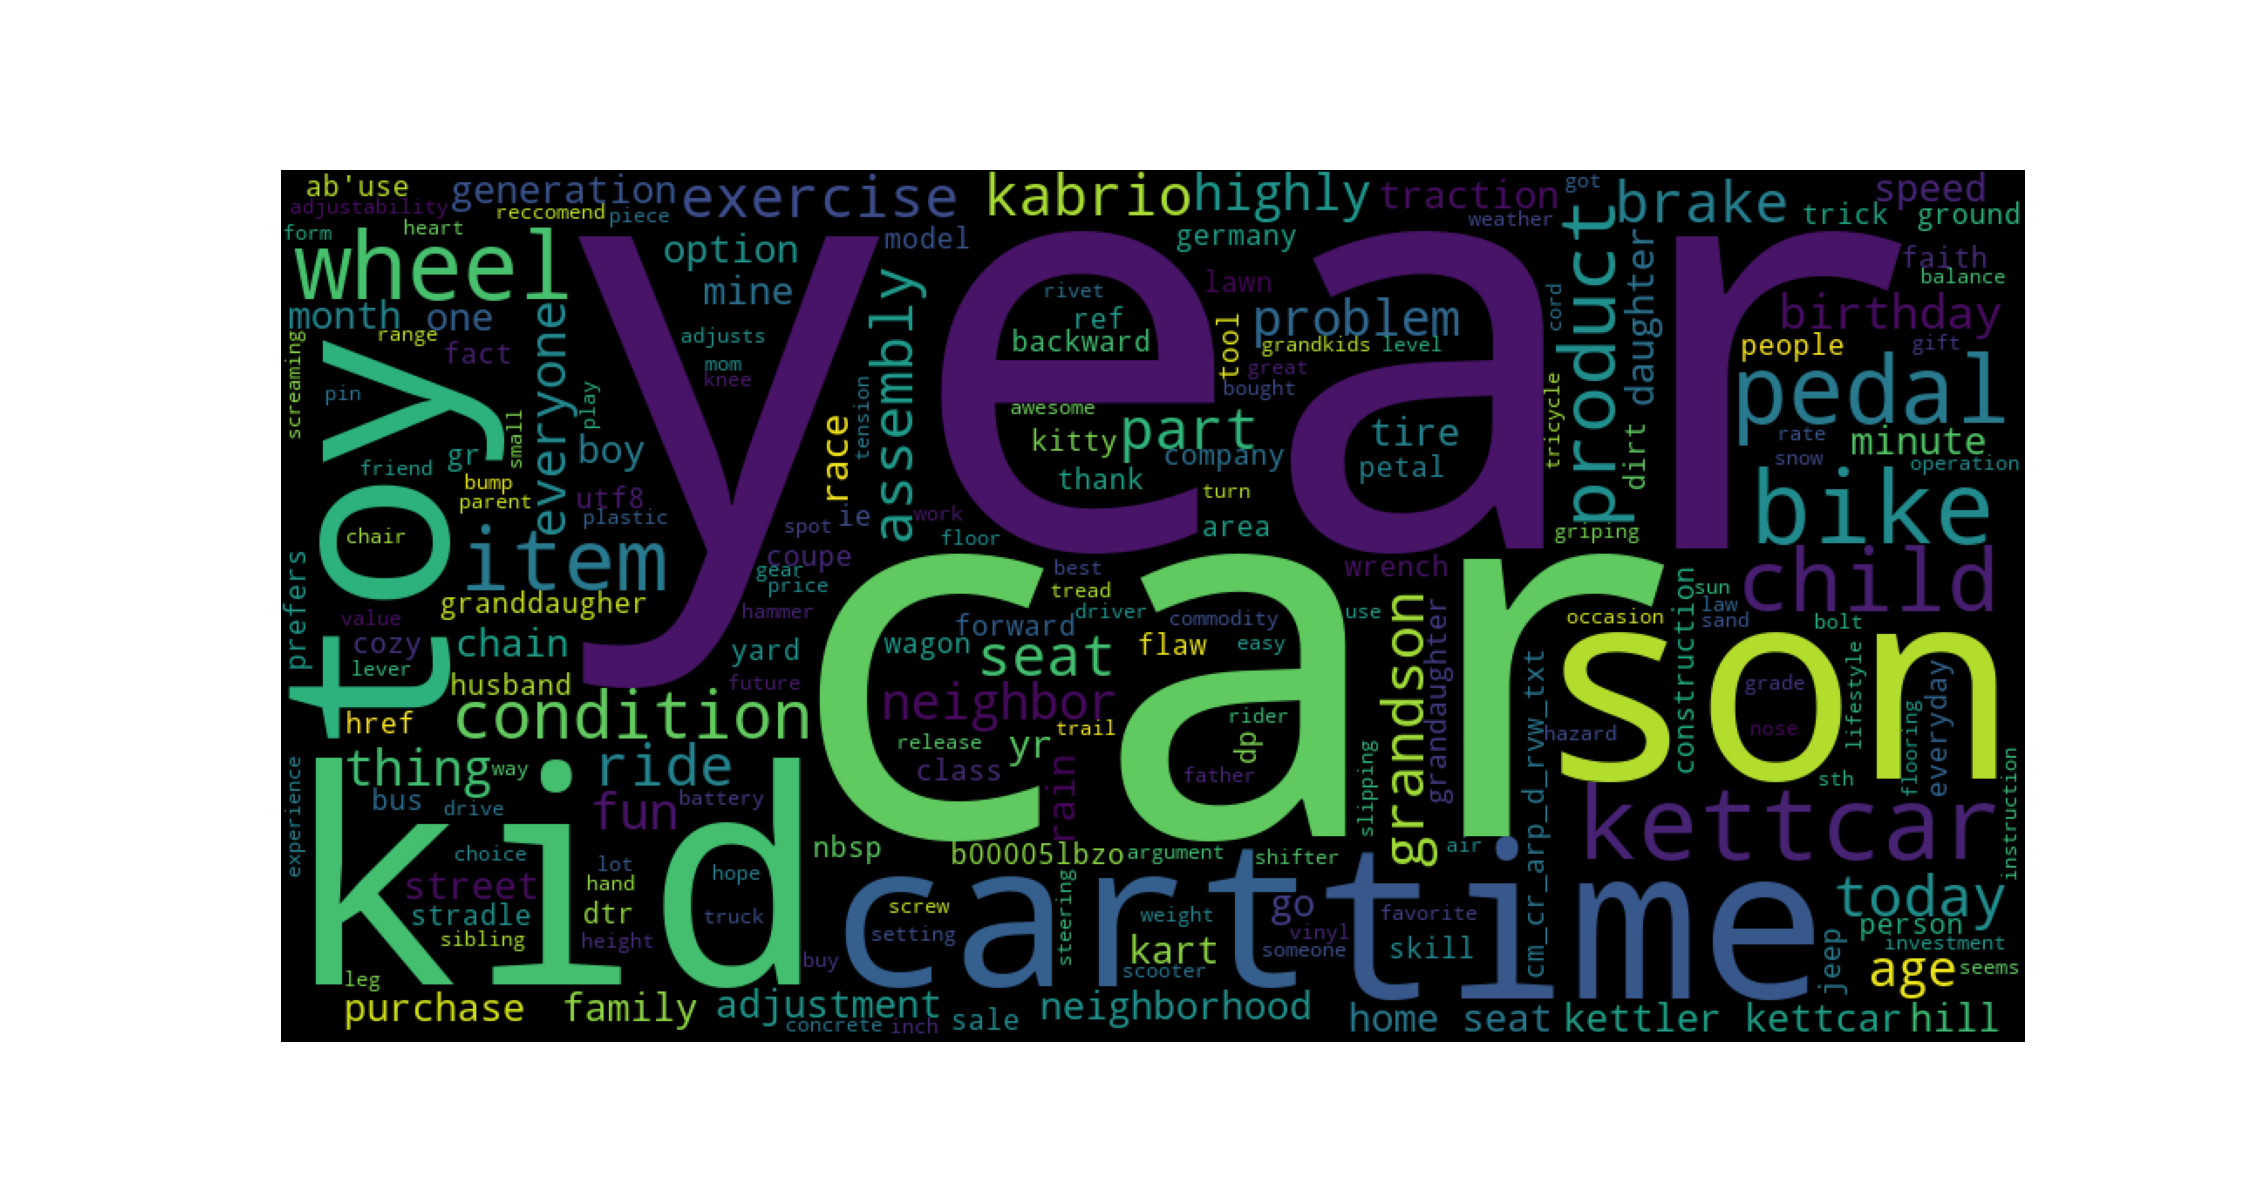

(-0.5, 999.5, 499.5, -0.5)

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generat, vishulize noun list
unique_string=(" ").join(all_nouns)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [14]:
#replaces simular words in list with a single word
def word_consolidation(word_list,consolidation_list,replace_word):
    new_list=[]
    
    for word in word_list:
        if word in consolidation_list:
            new_list.append(replace_word)
        else:
            new_list.append(word)
    return new_list

# Generate and output nouns to files

In [15]:
def output_nouns(f1,f2,asin, word_list, top_n=TOP_N):
    #print 10 most commen words
    c=Counter(word_list)
    count_n=c.most_common(top_n)
    pop_words=sorted(c, key = c.get, reverse = True)[:top_n]

    print("{} : {}".format(asin,count_n))
    
    #print words along with count
    print("{} : {}".format(asin,count_n), file = f1)
    
    #print top 10 words
    print("{},".format(asin), file = f2, end="")
    
    for word in pop_words:
        if word==pop_words[-1]:
            print("{}".format(word), file = f2, end="")
        else:
            print("{},".format(word), file = f2, end="")
        
    print("",file = f2)
    
    
    

    
#for all products get the top 10 nouns accross all reviews 
#get list of asins
asins=top_car_reviews["asin"].unique()
print(len(asins))
f_sufix="consolidated"
f_1_name="dataset/top_10_review_nouns_"+f_sufix+"_count.txt"
f_2_name="dataset/top_10_review_nouns_"+f_sufix+"_words.csv"

with open(f_1_name, "w+") as file_count, open(f_2_name, "w+") as file_words:
    #iterate over each product
    for asin in asins:
        #gets all reviews text for a given product as a list of strings
        review_list=get_reviews(top_car_reviews,asin)

        #get list of all nouns in all reviews
        #print(review_list)
        all_nouns=get_nouns_all_reviews(review_list)

        #preform cleaning on noun list 
        #lemmatize
        all_nouns=lem_list(all_nouns)

        #make all words lower cases
        all_nouns = [each_string.lower() for each_string in all_nouns]

        #remove stop words from list
        all_nouns = [word for word in all_nouns if word not in stopwords.words('english')]
        
        
        #remove words that are also in product title
        title_list=get_title_words(asin)
        all_nouns = [word for word in all_nouns if word not in title_list]
        
        
        
        #consolidate some words ie. words like 'kid', 'son', 'grandson', 'daughter', 'granddaughter', 'nephew', 'niece', 'child'
        #into single word "product_recipient"
        all_nouns=word_consolidation(all_nouns,PRODUCT_RECIPIENT_WORDS,PRODUCT_RECIPIENT)# recipient related words
        all_nouns=word_consolidation(all_nouns,PRODUCT_WORDS,PRODUCT)#product related words
        
        output_nouns(file_count,file_words,asin, all_nouns)
        

        

30
B00005LBZO : [('product', 80), ('product_recipient', 76), ('year', 40), ('time', 18), ('bike', 14), ('pedal', 12), ('seat', 10), ('wheel', 10), ('condition', 8), ('today', 6)]
B000GPLT68 : [('product', 92), ('product_recipient', 54), ('wheel', 21), ('time', 17), ('quality', 14), ('race', 12), ('gift', 11), ('year', 11), ('piece', 11), ('christmas', 10)]
B000Q9KPB4 : [('product', 54), ('model', 27), ('base', 14), ('quality', 13), ('wire', 11), ('box', 11), ('time', 10), ('corner', 8), ('top', 8), ('price', 8)]
B002AKKO6S : [('product_recipient', 25), ('string', 25), ('product', 17), ('year', 15), ('quality', 14), ('sound', 13), ('price', 11), ('tune', 9), ('body', 7), ('instrument', 6)]
B004KU83C8 : [('product', 38), ('product_recipient', 32), ('set', 17), ('quality', 9), ('thomas', 8), ('track', 8), ('year', 8), ('box', 6), ('engine', 6), ('fun', 6)]
B004LH01ZW : [('product_recipient', 34), ('product', 29), ('battery', 19), ('wheel', 11), ('light', 8), ('day', 8), ('minute', 7), ('r

# Rule based extraction
An advanced rule based approch to extract aspect words based on rules outlined in Venugopalana, Gupta's paper "An Unsupervised Hierarchical Rule Based Model for Aspect Term Extraction Augmented with Pruning Strategies"


In [16]:
#check of noun is in dobj relation with a verb
def find_dobj(text,noun, nlp=nlp):

    doc = nlp(text)
    for token in doc:
        #check if noun has dobj relation
        if token.dep_ == "dobj" and token.text==noun:
            return True

            #print(token.dep_,token.text,token.head.text)
            #print("{2}({3}-{6}, {0}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))
    return False

#check of noun is in njubj relation with a verb
def find_nsubj(text,noun, nlp=nlp):

    doc = nlp(text)
    for token in doc:
        #check if noun has dobj relation
        if token.dep_ == "nsubj" and token.text==noun:
            return True

    return False

#find if the word hhas a relatiion with a copula verb
def find_copula(text,noun, nlp=nlp):

    doc = nlp(text)
    for token in doc:
        #check if noun has modifier relation
        #print("{2}({3}-{6}, {0}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))        
        if token.dep_ == "cop" and token.head.text==noun:
            return True
    return False

#find the NER tag for a given word 

def find_ner_tag(text,word, nlp=nlp):
    doc = nlp(text)
    for token in doc:
        #check if noun has dobj relation
        #print( token.text, token.ent_type_)
        if token.text==word:
            return token.ent_type_
    return ""

#check that sentence contains atleast one opinion word 
def opin_word_in_sent(text,opin_lex=opinion_lexicon.words()):
    
    for word in nltk.word_tokenize(text):
        if word.lower() in opin_lex:
            return True
    return False

#an advanced rule based approch based on rules outlined in Venugopalana, Gupta's paper "An Unsupervised Hierarchical Rule Based Model for Aspect Term Extraction Augmented with Pruning Strategies"
def get_nouns_rule_based(text,opin_lex=opinion_lexicon.words()):
    
    if isNaN(text):
        return []
    sentences = nltk.sent_tokenize(text) #tokenize sentences
    aspect_words = [] #empty to array to hold all nouns

    
    for sentence in sentences:
        pos_tag_list=nltk.pos_tag(nltk.word_tokenize(str(sentence)))
        
        i=0
        for word,pos in pos_tag_list:
            pre_word=""
            pre_pos=""
            word=word.lower()
            if i>0:
                pre_word=pos_tag_list[i-1][0].lower()
                pre_pos=pos_tag_list[i-1][1]
            
            #R1: if word is a noun and preceded by an adjective which is not an opinion word then 
            #concatenate the word and its preceding word and append it to aspect[i]
            if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and \
            (pre_pos == 'JJ' or pre_pos == 'JJR' or pre_pos == 'JJS') and pre_word not in opin_lex:
                aspect_words.append(pre_word+" "+word)
                    
            #R2: if word is a noun and preceded by another noun then concatenate the word and
            #its preceding word and append it to aspect[i]
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and \
            (pre_pos == 'NN' or pre_pos == 'NNP' or pre_pos == 'NNS' or pre_pos == "NNPS"):   
                aspect_words.append(pre_word+" "+word)
                
            #R3: if word is a noun and preceded by an adjective which is an opinion word then
            #append the word to aspect[i]
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and \
            (pre_pos == 'JJ' or pre_pos == 'JJR' or pre_pos == 'JJS') and pre_word in opin_lex:
                aspect_words.append(word)
            
            #R4: if word is a noun and is in a dobj relationship with a verb in the sentence then
            #append the word in aspect[i]
            #TODO see below functions
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and find_dobj(sentence, word):
                aspect_words.append(word)
                
            #R5: if word is a noun and is in a nsubj relationship with an adjective in the sentence
            #then append the word in aspect[i]
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and find_nsubj(sentence, word):
                aspect_words.append(word)
                
            #R6: if the sentence S[i] contains a SUBJECT VERB and if the word has any adverbial
            #or adjective modifier which is an opinion word append the word to aspect[i]
            #elif :
            
            #R7: if word is a noun and is in a modifier relationship with a copula verb in the
            #sentence then append the word to aspect[i]
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and find_copula(sentence,word):
                aspect_words.append(word)
                
            #R8: if word is a noun and if the previous word is not a preposition of place or a word
            #corresponding to an NER tag of {'TIME', 'ORDINAL', 'NUMBER', 'DATE','PERCENT’} 
            #and there is atleast one opinion word in the sentence , then append the word to aspect[i]
            elif (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS') and \
            find_ner_tag(sentence, pre_word) not in ['TIME','ORDINAL','DATE','QUANTITY','PERCENT'] and \
            opin_word_in_sent(sentence):
                aspect_words.append(word)
            i+=1   
            
    return aspect_words
    

aspect_list=get_nouns_rule_based(test_review)
print(len(aspect_list))
aspect_list

26


['ride',
 'old son',
 'son prefers',
 'ride-on toys',
 'bike',
 'motorized jeep',
 'cozy',
 'cozy coupe',
 'plastic car',
 'wagon',
 'stradle',
 'wheel',
 'wheel bus',
 'car',
 'car everyday',
 'neighbor',
 'yard sale',
 'son',
 'petals',
 'son',
 'car',
 'other bike',
 'ground',
 'bike',
 'toys',
 'exercise']

In [17]:
aspect_list=get_nouns(test_review)
print(len(aspect_list))
aspect_list

30


['ride',
 'year',
 'son',
 'prefers',
 'toys',
 'bike',
 'Jeep',
 'cozy',
 'coupe',
 'car',
 'wagon',
 'stradle',
 'wheel',
 'bus',
 'car',
 'everyday',
 'toy',
 'neighbor',
 'Kettcar',
 'sale',
 'son',
 'petals',
 'son',
 'car',
 'bike',
 'ground',
 'bike',
 'toys',
 'neighborhood',
 'exercise']

In [18]:
print(len(get_nouns_all_reviews(review_list, get_fuc=get_nouns)))
#uses the advanced rule base fuction
get_nouns_all_reviews(review_list, get_fuc=get_nouns_rule_based)

262


['european plug',
 'adapter ..',
 'battery',
 'wires',
 'tryingto recharge',
 'battery',
 'wires',
 'dollar-store quality',
 'item',
 'item today',
 'great',
 'great',
 'little rc',
 'rc car',
 'shape',
 'spins',
 'straight line',
 'rechargeable battery',
 'battery pack',
 'car',
 'less batteries',
 'other cars',
 'same picture',
 'con',
 'controls',
 'drive',
 'drive wheel',
 'actual turn',
 'son',
 'direction',
 'car',
 'foreign plug',
 'order',
 'adapter',
 'u.s',
 'house',
 'surfaces',
 'few stars',
 'small defect',
 'car',
 'level cars',
 'performance',
 'toy',
 'matter',
 'remote',
 'work',
 'was',
 'christmas',
 'little boy',
 'instructions',
 'screw',
 'screw driver',
 'battery',
 'work',
 'frequency',
 'red thinking',
 'same time',
 'controlled cars',
 'car',
 'money',
 'short battery',
 'battery life',
 'minutes tops',
 'n christmas',
 'son',
 'car',
 'christmas',
 'dud',
 'lights',
 'only thing',
 'work',
 'top',
 'remote',
 'power',
 'power control',
 'only way',
 'batterie

In [19]:
#for all products get the top 10 nouns accross all reviews  with rule based approch
#get list of asins
asins=top_car_reviews["asin"].unique()
print(len(asins))

f_sufix="rule_based"
f_1_name="dataset/top_10_review_nouns_"+f_sufix+"_count.txt"
f_2_name="dataset/top_10_review_nouns_"+f_sufix+"_words.csv"

with open(f_1_name, "w+") as file_count, open(f_2_name, "w+") as file_words:
    #iterate over each product
    i=0
    for asin in asins:
        print("Starting product: "+ asin)
        #gets all reviews text for a given product as a list of strings
        review_list=get_reviews(top_car_reviews,asin)

        #get list of all nouns in all reviews
        #print(review_list)
        all_nouns=get_nouns_all_reviews(review_list,get_fuc=get_nouns_rule_based)

        #preform cleaning on noun list 
        #lemmatize
        all_nouns=lem_list(all_nouns)

        #make all words lower cases
        all_nouns = [each_string.lower() for each_string in all_nouns]

        #remove stop words from list
        all_nouns = [word for word in all_nouns if word not in stopwords.words('english')+["class="]]
        
        
        #remove words that are also in product title
        title_list=get_title_words(asin)
        all_nouns = [word for word in all_nouns if word not in title_list]
        
        
        
        #consolidate some words ie. words like 'kid', 'son', 'grandson', 'daughter', 'granddaughter', 'nephew', 'niece', 'child'
        #into single word "product_recipient"
        all_nouns=word_consolidation(all_nouns,PRODUCT_RECIPIENT_WORDS,PRODUCT_RECIPIENT)# recipient related words
        all_nouns=word_consolidation(all_nouns,PRODUCT_WORDS,PRODUCT)#product related words
        
        output_nouns(file_count,file_words,asin, all_nouns)
        
        print("Completed product: {}, {}/{}".format(asin,i,len(asins)))
        i+=1
        


30
Starting product: B00005LBZO
B00005LBZO : [('product', 58), ('product_recipient', 48), ('wheel', 10), ('time', 8), ('bike', 8), ('pedal', 8), ('today', 6), ('condition', 6), ('year', 6), ('yr', 4)]
Completed product: B00005LBZO, 0/30
Starting product: B000GPLT68
B000GPLT68 : [('product', 61), ('product_recipient', 36), ('race car', 12), ('wheel', 11), ('quality', 11), ('screw', 8), ('time', 8), ('gift', 6), ('plastic', 6), ('box', 5)]
Completed product: B000GPLT68, 1/30
Starting product: B000Q9KPB4
B000Q9KPB4 : [('product', 37), ('display case', 21), ('quality', 12), ('model', 11), ('box', 9), ('corner', 8), ('money', 7), ('price', 7), ('time', 6), ('product_recipient', 6)]
Completed product: B000Q9KPB4, 2/30
Starting product: B002AKKO6S
B002AKKO6S : [('product_recipient', 16), ('string', 12), ('sound', 12), ('product', 9), ('price', 9), ('quality', 6), ('tune', 6), ('instrument', 5), ('full size', 4), ('action', 4)]
Completed product: B002AKKO6S, 3/30
Starting product: B004KU83C8
B

# Heuristic rule based
Used a heuristic combining the number of times a aspect word appears along with tthe polarity

In [20]:
def get_pop_nouns(asin, word_list, top_n=TOP_N):
    #print 10 most commen words
    c=Counter(word_list)
    count_n=c.most_common(top_n)
    pop_words=sorted(c, key = c.get, reverse = True)[:top_n]
    return pop_words

#for all products get the top 100 nouns accross all reviews  with rule based approch
#get list of asins
asins=top_car_reviews["asin"].unique()
print(len(asins))
all_pop_nouns=[]
#iterate over each product
i=0
for asin in asins:
    print("Starting product: "+ asin)
    #gets all reviews text for a given product as a list of strings
    review_list=get_reviews(top_car_reviews,asin)

    #get list of all nouns in all reviews
    #print(review_list)
    all_nouns=get_nouns_all_reviews(review_list,get_fuc=get_nouns_rule_based)

    #preform cleaning on noun list 
    #lemmatize
    all_nouns=lem_list(all_nouns)

    #make all words lower cases
    all_nouns = [each_string.lower() for each_string in all_nouns]

    #remove stop words from list
    all_nouns = [word for word in all_nouns if word not in stopwords.words('english')+["class="]]


    #remove words that are also in product title
    title_list=get_title_words(asin)
    all_nouns = [word for word in all_nouns if word not in title_list]



    #consolidate some words ie. words like 'kid', 'son', 'grandson', 'daughter', 'granddaughter', 'nephew', 'niece', 'child'
    #into single word "product_recipient"
    all_nouns=word_consolidation(all_nouns,PRODUCT_RECIPIENT_WORDS,PRODUCT_RECIPIENT)# recipient related words
    all_nouns=word_consolidation(all_nouns,PRODUCT_WORDS,PRODUCT)#product related words

    all_pop_nouns.append(get_pop_nouns(asin, all_nouns,100))

    print("Completed product: {}, {}/{}".format(asin,i,len(asins)))
    i+=1
    

30
Starting product: B00005LBZO
Completed product: B00005LBZO, 0/30
Starting product: B000GPLT68
Completed product: B000GPLT68, 1/30
Starting product: B000Q9KPB4
Completed product: B000Q9KPB4, 2/30
Starting product: B002AKKO6S
Completed product: B002AKKO6S, 3/30
Starting product: B004KU83C8
Completed product: B004KU83C8, 4/30
Starting product: B004LH01ZW
Completed product: B004LH01ZW, 5/30
Starting product: B006RKH1I6
Completed product: B006RKH1I6, 6/30
Starting product: B006RKBK0Q
Completed product: B006RKBK0Q, 7/30
Starting product: B006RKFHBY
Completed product: B006RKFHBY, 8/30
Starting product: B00AM9SZWO
Completed product: B00AM9SZWO, 9/30
Starting product: B00APTT9SU
Completed product: B00APTT9SU, 10/30
Starting product: B00E849LS6
Completed product: B00E849LS6, 11/30
Starting product: B00J97X2YG
Completed product: B00J97X2YG, 12/30
Starting product: B00JPTG45C
Completed product: B00JPTG45C, 13/30
Starting product: B00KFBS5QA
Completed product: B00KFBS5QA, 14/30
Starting product:

In [21]:

with open("dataset/top_100_rule_based.txt","wb") as f:
    pickle.dump(all_pop_nouns,f)

In [22]:
with open("dataset/top_100_rule_based.txt","rb") as f:
    all_pop_nouns=pickle.load(f)

In [23]:
#get the largest polarity (positive or negitve) for a aspect
def get_sent_polarity(sentence):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)
    if ss["neg"]>= ss["pos"]:
        return ss["neg"]
    else:
        return ss["pos"]
    
get_sent_polarity("VADER is smart, handsome, and funny!")#test

0.752

In [24]:
def isNaN(num):
    try:
        num=float(num)
    except:
        return False 
    return math.isnan(num)
'''
takes a list of words and lemmatize then all, returns list of lemmatize words
'''
def lem_list(words):
    lemmatizer = WordNetLemmatizer()
    
    lem_list=[]
    
    for word in words:
        lem_list.append(lemmatizer.lemmatize(word))
    return lem_list

#Gets the numer of times an aspect appears in the reviews, as well as the acumilated polarity
def get_count_and_polarity(aspect, reviews):
    count=0
    arg_polarity=0
    
    #get list of consilidated words
    aspect_words=[]
    if aspect == PRODUCT:
        aspect_words=PRODUCT_WORDS
    elif aspect==PRODUCT_RECIPIENT:
        aspect_words=PRODUCT_RECIPIENT_WORDS
    
    for review in reviews:
        #print(review)
        #tokenize into sentences
        #print()
        
        if isNaN(review):
            sents=[]
            #print("NaN!")
        else:
            sents=sent_tokenize(review)
        #print(len(sents))
        
        for sent in sents:
            #tokenize into words and make lowercase
            sent=sent.lower()
            word_list=word_tokenize(sent)
        
            #lemitize words
            word_list=lem_list(word_list)
            #if sentence word list has aspect word add to cout and polarity
            if type(aspect) is str and aspect in word_list: 
                count+=1
                arg_polarity+=get_sent_polarity(sent)
            elif any(x in word_list for x in aspect_words):#handel consolidated words
                count+=1
                arg_polarity+=get_sent_polarity(sent)
            elif " " in aspect and sent.find(aspect)!=-1:#use for multi word aspect
                count+=1
                arg_polarity+=get_sent_polarity(sent)
    return count, arg_polarity


tricky_sentences = [
"Most automated sentiment analysis tools are shit.",
"VADER sentiment analysis is the shit.",
"Sentiment analysis has never been good.",
"Sentiment analysis with VADER has never been this good.",
"Warren Beatty has never been so entertaining.",
"I won't say that the movie is astounding and I wouldn't claim that \
the movie is too banal either.",
"I like to hate Michael Bay films, but I couldn't fault this one",
"I like to hate Michael Bay films, BUT I couldn't help but fault this one",
"It's one thing to watch an Uwe Boll film, but another thing entirely \
to pay for it",
"The movie was too good",
"This movie was actually neither that funny, nor super witty.",
"This movie doesn't care about cleverness, wit or any other kind of \
intelligent humor.",
"Those who find ugly meanings in beautiful things are corrupt without \
being charming.",
"There are slow and repetitive parts, BUT it has just enough spice to \
keep it interesting.",
"The script is not fantastic, but the acting is decent and the cinematography \
is EXCELLENT!",
"Roger Dodger is one of the most compelling variations on this theme.",
"Roger Dodger is one of the least compelling variations on this theme.",
"Roger Dodger is at least compelling as a variation on the theme.",
"they fall in love with the product",
"but then it breaks",
"usually around the time the 90 day warranty expires",
"the twin towers collapsed today",
"However, Mr. Carter solemnly argues, his client carried out the kidnapping \
under orders and in the ''least offensive way possible."]

get_count_and_polarity("theme",tricky_sentences)
get_count_and_polarity("roger dodger",tricky_sentences)

(3, 0.4580000000000001)

In [25]:
#Takes a list of aspects, and reviews and generates a count and polarity huristic for each aspect
def get_aspect_heuristics_list(aspect_list, reviews):
    aspect_count=[]
    aspect_polarity=[]
    
    for aspect in aspect_list:
        count, pol = get_count_and_polarity(aspect, reviews)
        aspect_count.append(count)
        aspect_polarity.append(pol)
    return aspect_count, aspect_polarity

<IPython.core.display.Javascript object>


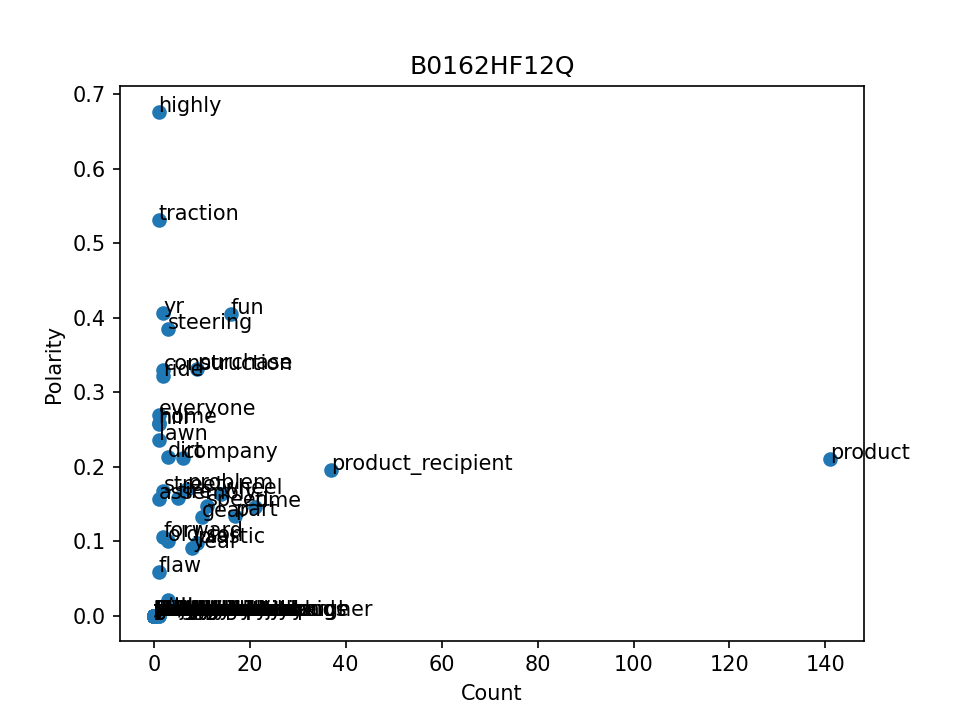

<IPython.core.display.Javascript object>


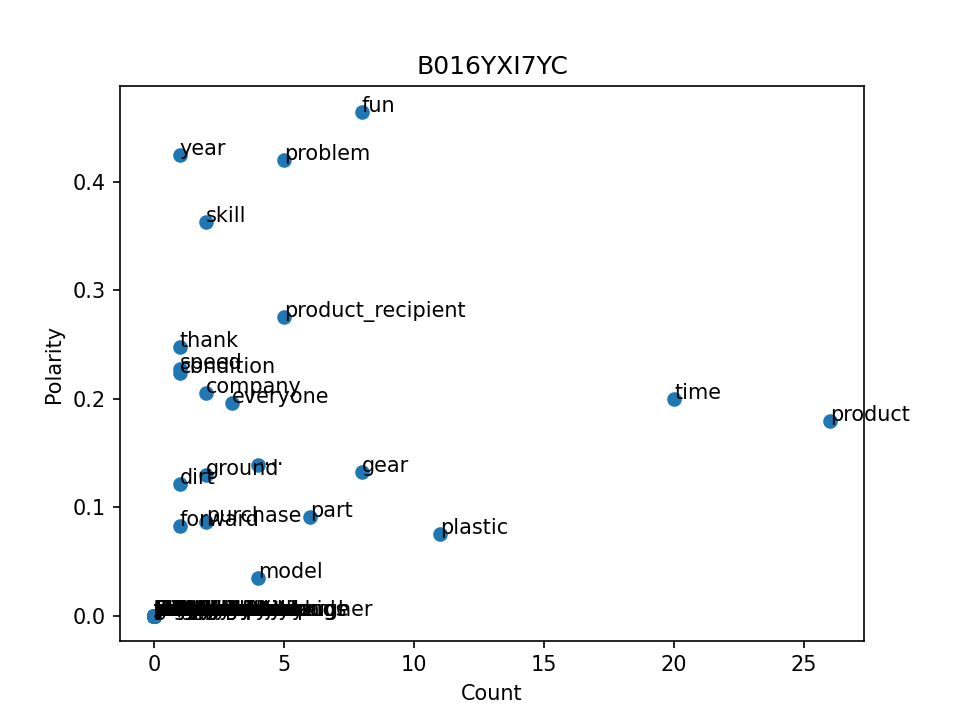

<IPython.core.display.Javascript object>


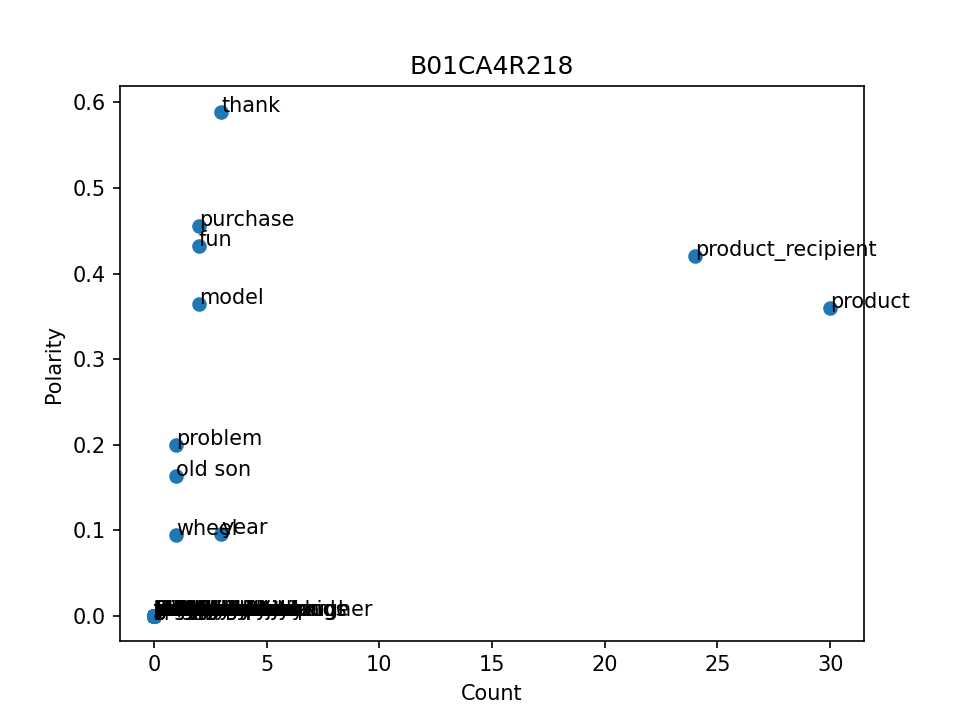

<IPython.core.display.Javascript object>


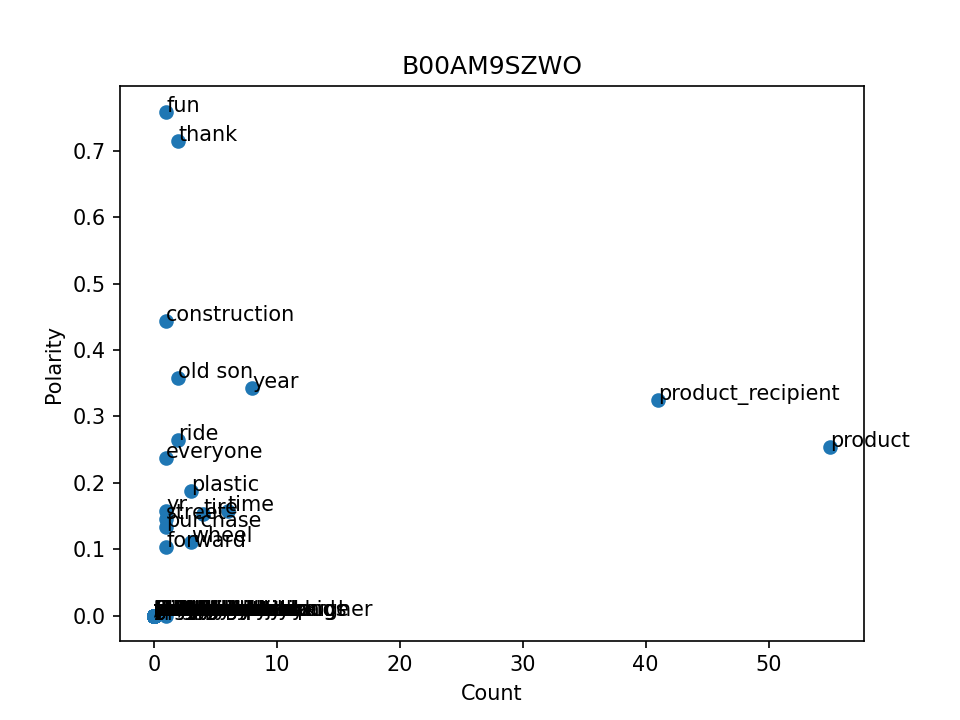

<IPython.core.display.Javascript object>


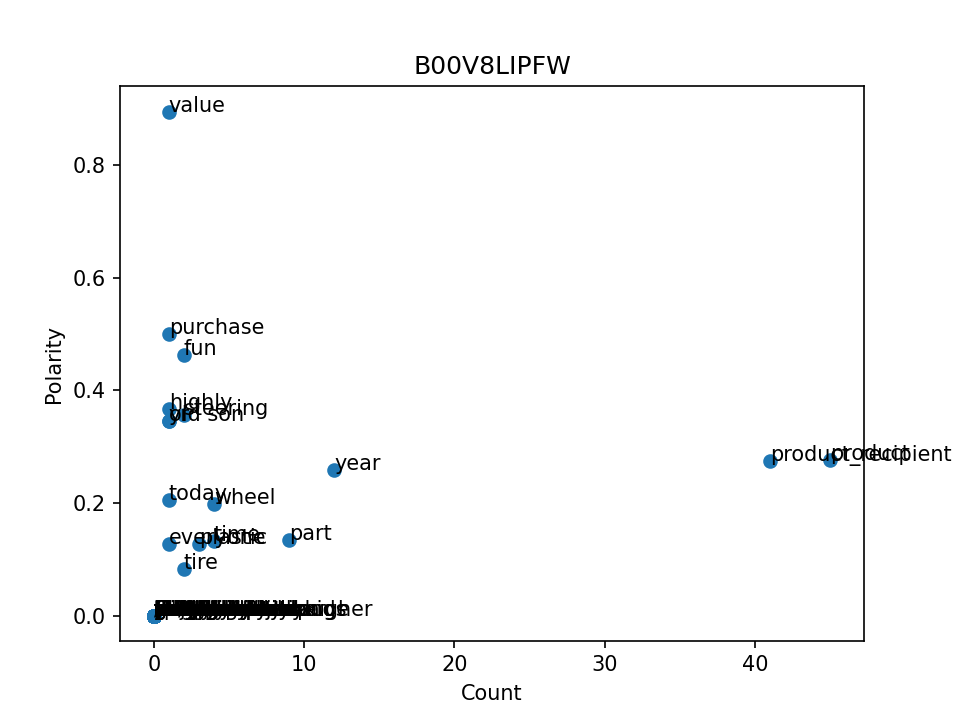

In [36]:
#gets all reviews for a given product as a list of strings
def get_reviews(df, asin):
    return df[df["asin"]==asin]["reviewText"].tolist()
#get list of asins
asins=top_car_reviews["asin"].unique() 

sample_asin=random.sample(asins.tolist(), 5)
i=0
#get aspect and emotions for each asin (product)
for asin in sample_asin:
    review_list=get_reviews(top_car_reviews,asin)
    aspect_list=all_pop_nouns[i]
    
    reviews=get_reviews(top_car_reviews,asin)
    ##Gets the numer of times an aspect appears in the reviews, as well as the acumilated polarity for each aspect
    aspect_count, aspect_polarity=get_aspect_heuristics_list(aspect_list,reviews)
    #print(asin)
    #print(len(aspect_list))
    #print(len(aspect_count))
    #print(len(aspect_polarity))
    
    #get average polarity per aspect by dividing by count
    aspect_count=np.array(aspect_count)
    aspect_polarity=np.array(aspect_polarity)
    
    avg_aspect_pol = np.divide(aspect_polarity, aspect_count, out=np.zeros_like(aspect_polarity), where=aspect_count!=0)
    #print(avg_aspect_pol)
    
    #show figure 
    fig, ax = plt.subplots()
    ax.scatter(aspect_count, avg_aspect_pol)
    ax.set_title(asin)
    ax.set_xlabel("Count")
    ax.set_ylabel("Polarity")
    for j, txt in enumerate(aspect_list):
        ax.annotate(txt, (aspect_count[j], avg_aspect_pol[j]))
    #break
    

In [27]:
#sort aspect and output based on heuristic of each aspect
def output_heuristic_aspects(f,asin, aspect_list,aspect_value, top_n=TOP_N):
    
    #sort aspect based on heuristic
    zipped_lists = zip(aspect_value, aspect_list)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    aspect_value, aspect_list = [ list(tuple) for tuple in  tuples]
    aspect_list.reverse()
    aspect_value.reverse()
    
    
    #print(aspect_list)
    #print(aspect_value)
    
    i=0
    #print top 10 words
    #get top n where heuristic_importance is greater then 0.1
    print("{},".format(asin), file = f, end="")
    for word in aspect_list:
        if word==aspect_list[-1]:
            print("{}".format(word), file = f, end="")
        elif aspect_value[i+1]<0.1 or i+1==top_n:#if value is less than 0.1 stop printing
            print("{}".format(word), file = f, end="")
            break
        else:
            print("{},".format(word), file = f, end="")
        i+=1
    print("",file = f)
a=['a','b','c','d','e']
b=[8,1,6,3,7]
with open("dataset/test_h_out.csv","w+") as f:
    output_heuristic_aspects(f,"000",a,b)

In [28]:
#gets all reviews for a given product as a list of strings
def get_reviews(df, asin):
    return df[df["asin"]==asin]["reviewText"].tolist()
#get list of asins
asins=top_car_reviews["asin"].unique() 

i=0

with open("dataset/top_10_review_nouns_rule_heuristic_words.csv","w+") as f:
    #get aspect and emotions for each asin (product)
    for asin in asins:
        print("Started product "+asin)
        review_list=get_reviews(top_car_reviews,asin)
        aspect_list=all_pop_nouns[i]

        reviews=get_reviews(top_car_reviews,asin)
        ##Gets the numer of times an aspect appears in the reviews, as well as the acumilated polarity for each aspect
        aspect_count, aspect_polarity=get_aspect_heuristics_list(aspect_list,reviews)
        #print(asin)
        #print(len(aspect_list))
        #print(len(aspect_count))
        #print(len(aspect_polarity))

        #get average polarity per aspect by dividing by count
        aspect_count=np.array(aspect_count)
        aspect_polarity=np.array(aspect_polarity)

        avg_aspect_pol = np.divide(aspect_polarity, aspect_count, out=np.zeros_like(aspect_polarity), where=aspect_count!=0)
        #print(avg_aspect_pol)

        #output huristicly sorted values
        #=(polarity*count^2)/10
        heuristic_importance=(avg_aspect_pol*aspect_count*aspect_count)/10

        #sort aspect and output based on heuristic
        #get top n where heuristic_importance is greater then 0
        output_heuristic_aspects(f,asin,aspect_list,heuristic_importance)
        
        print("Cmpleted product {}... {}/30".format(asin,i+1))
        
        i+=1

Started product B00005LBZO
Cmpleted product B00005LBZO... 1/30
Started product B000GPLT68
Cmpleted product B000GPLT68... 2/30
Started product B000Q9KPB4
Cmpleted product B000Q9KPB4... 3/30
Started product B002AKKO6S
Cmpleted product B002AKKO6S... 4/30
Started product B004KU83C8
Cmpleted product B004KU83C8... 5/30
Started product B004LH01ZW
Cmpleted product B004LH01ZW... 6/30
Started product B006RKH1I6
Cmpleted product B006RKH1I6... 7/30
Started product B006RKBK0Q
Cmpleted product B006RKBK0Q... 8/30
Started product B006RKFHBY
Cmpleted product B006RKFHBY... 9/30
Started product B00AM9SZWO
Cmpleted product B00AM9SZWO... 10/30
Started product B00APTT9SU
Cmpleted product B00APTT9SU... 11/30
Started product B00E849LS6
Cmpleted product B00E849LS6... 12/30
Started product B00J97X2YG
Cmpleted product B00J97X2YG... 13/30
Started product B00JPTG45C
Cmpleted product B00JPTG45C... 14/30
Started product B00KFBS5QA
Cmpleted product B00KFBS5QA... 15/30
Started product B00KS6ADQW
Cmpleted product B00KS